## Objective:
    * To identify the credit card digits.
## Applications:
    * Used with old cards without NFC
    * Same procedure can be used for Identification/Attendence systems.

### This code was studiend and modified from
*  https://www.udemy.com/course/master-deep-learning-computer-visiontm-cnn-ssd-yolo-gans/

# Imports

In [1]:
import cv2 

import os
import glob
import itertools
import imutils

import tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,Dense,Flatten,GlobalMaxPooling2D,MaxPooling2D,BatchNormalization,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image

from sklearn.metrics import confusion_matrix,classification_report
from skimage.filters import threshold_local

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Fix
from google.colab.patches import cv2_imshow



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preparation

In [5]:
digits1=cv2.imread(r'/content/digits1.jpg',0)
digits2=cv2.imread(r'/content/digits2.jpg',0)

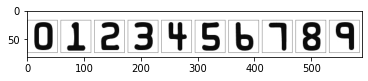

In [6]:
plt.imshow(digits1,cmap='gray')

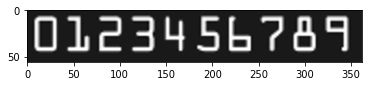

In [7]:
plt.imshow(digits2,cmap='gray')

In [8]:
digits1.shape


(81, 589)

In [9]:
digits2.shape

(56, 362)

In [ ]:
# !rm -r '/content/Dataset'

In [10]:
for i in range(10):
    dir_path="./Dataset/digits/train/"+str(i)
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        
    dir_path="./Dataset/digits/test/"+str(i)
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

In [11]:
os.listdir()

['.config',
 'digits1.jpg',
 'drive',
 'Dataset',
 '.ipynb_checkpoints',
 'digits2.jpg',
 'sample_data']

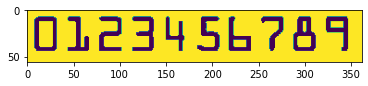

In [12]:
cc1 = cv2.imread(r'/content/digits2.jpg', 0)
_, th2 = cv2.threshold(cc1, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(th2)


In [13]:
region = [(0, 0), (35, 48)]

In [14]:
top_left_y = region[0][1]
bottom_right_y = region[1][1]
top_left_x = region[0][0]
bottom_right_x = region[1][0]

In [15]:
roi = cc1[top_left_y:bottom_right_y, top_left_x:bottom_right_x]

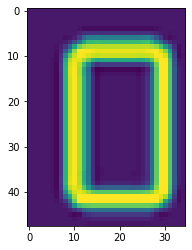

In [16]:
plt.imshow(roi)

In [17]:
train_datagen=ImageDataGenerator(
    rescale=1./255.,
    rotation_range=1,
    shear_range=0.05,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=False,
    fill_mode="nearest"
)
test_datagen=ImageDataGenerator(rescale=1./255.)


In [18]:
region = [(0, 0), (35, 48)]
top_left_y = region[0][1]
bottom_right_y = region[1][1]
top_left_x = region[0][0]
bottom_right_x = region[1][0]


for i in range(10):
    roi = cc1[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
    
    path="./{}/".format(str(i))

    train_file_name="./Dataset/digits/train/{}/_{}_0.png".format(i,i)
    test_file_name="./Dataset/digits/test/{}/_{}_0.png".format(i,i)
    
    cv2.imwrite(train_file_name,roi)
    cv2.imwrite(test_file_name,roi)
    top_left_x = top_left_x + 35
    bottom_right_x = bottom_right_x + 35
    

In [20]:
W,H,C=32,32,3
BATCH_SIZE=32

In [21]:
train_data_dir="./Dataset/digits/train"
test_data_dir="./Dataset/digits/test"


train_generator=train_datagen.flow_from_directory(
    train_data_dir,
    color_mode="rgb",
    target_size=(W,H),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)
test_generator=test_datagen.flow_from_directory(
    test_data_dir,
    color_mode="rgb",
    target_size=(W,H),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

Found 10 images belonging to 10 classes.
Found 10 images belonging to 10 classes.


## Data synthesis

In [22]:
MIN_SAMPLES=1000

In [23]:
for i in train_generator.class_indices.keys():
    j=i
    print(f"Generating Train Data {i}")
    path=str("./Dataset/digits/train/{}/".format(i))
    files = os.listdir("./Dataset/digits/train/{}/".format(i)) 
    number_files = len(files)
    images = np.array([cv2.imread(file) for file in glob.glob(path+'*.png')])

    if number_files > MIN_SAMPLES:
        continue

    count=0

    for batch in train_datagen.flow(images, batch_size=1,
                        save_to_dir=path, save_prefix="N", save_format='png'):
        count+=1
        if count>MIN_SAMPLES-number_files:
            break

Generating Train Data 0
Generating Train Data 1
Generating Train Data 2
Generating Train Data 3
Generating Train Data 4
Generating Train Data 5
Generating Train Data 6
Generating Train Data 7
Generating Train Data 8
Generating Train Data 9


In [24]:
MIN_SAMPLES=250

In [25]:
for i in train_generator.class_indices.keys():
    j=i
    print(f"Generating Test Data {i}")
    path=str("./Dataset/digits/test/{}/".format(i))
    files = os.listdir("./Dataset/digits/test/{}/".format(i)) 
    number_files = len(files)
    images = np.array([cv2.imread(file) for file in glob.glob(path+'*.png')])

    if number_files > MIN_SAMPLES:
        continue

    count=0

    for batch in train_datagen.flow(images, batch_size=1,
                        save_to_dir=path, save_prefix="N", save_format='png'):
        count+=1
        if count>MIN_SAMPLES-number_files:
            break

Generating Test Data 0
Generating Test Data 1
Generating Test Data 2
Generating Test Data 3
Generating Test Data 4
Generating Test Data 5
Generating Test Data 6
Generating Test Data 7
Generating Test Data 8
Generating Test Data 9


In [26]:
train_generator=train_datagen.flow_from_directory(
    train_data_dir,
    color_mode="rgb",
    target_size=(W,H),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)
test_generator=test_datagen.flow_from_directory(
    test_data_dir,
    color_mode="rgb",
    target_size=(W,H),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

Found 9556 images belonging to 10 classes.
Found 2476 images belonging to 10 classes.


In [27]:
train_samples=9556
test_samples=2476
num_classes=10


# Modelling

## Model creation

In [28]:
model_digits=tf.keras.models.Sequential([
        Conv2D(32,(2,2),padding="same",input_shape=(W,H,C),activation="relu"), 
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.2),

        Conv2D(64,(2,2),padding="same",activation="relu"),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.2),

        Conv2D(128,(2,2),padding="same",activation="relu"),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.2),

        Conv2D(256,(2,2),padding="same",activation="relu"),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.2),

        Conv2D(512,(2,2),padding="same",activation="relu"),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.2),

        Flatten(),
        Dense(512,activation="relu"),
        BatchNormalization(),
        Dropout(0.2),

        Dense(256,activation="relu"),
        BatchNormalization(),
        Dropout(0.2),

        Dense(128,activation="relu"),
        BatchNormalization(),
        Dropout(0.2),

        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.2),

        Dense(32,activation="relu"),
        BatchNormalization(),
        Dropout(0.20),

        Dense(num_classes,activation="softmax")

])

In [29]:
model_digits.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        416       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

In [30]:
checkpoint=ModelCheckpoint("./Dataset/trained_model/digits.hd5",monitor="val_loss",mode="min",
                           save_best_only=True,verbose=1)

earlystop=EarlyStopping(monitor="val_loss",min_delta=0,patience=6,verbose=1,restore_best_weights=True)

reduce_lr=ReduceLROnPlateau(monitor="val_loss",factor=0.2,patience=2,verbose=1,min_delta=0.0001)

callbacks=[checkpoint,earlystop,reduce_lr]

In [31]:
model_digits.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

## Model training

In [32]:
epochs=50
history=model_digits.fit_generator(train_generator,steps_per_epoch=train_samples//BATCH_SIZE,
                            epochs=epochs,callbacks=callbacks,
                            validation_data=test_generator,
                            validation_steps=test_samples//BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
298/298 [==============================] - 46s 50ms/step - loss: 0.9246 - accuracy: 0.7247 - val_loss: 2.6740 - val_accuracy: 0.2009

Epoch 00001: val_loss improved from inf to 2.67399, saving model to ./Dataset/trained_model/digits.hd5
INFO:tensorflow:Assets written to: ./Dataset/trained_model/digits.hd5/assets
Epoch 2/50
298/298 [==============================] - 14s 47ms/step - loss: 0.1049 - accuracy: 0.9854 - val_loss: 0.0423 - val_accuracy: 0.9955

Epoch 00002: val_loss improved from 2.67399 to 0.04226, saving model to ./Dataset/trained_model/digits.hd5
INFO:tensorflow:Assets written to: ./Dataset/trained_model/digits.hd5/assets
Epoch 3/50
298/298 [==============================] - 14s 48ms/step - loss: 0.0460 - accuracy: 0.9938 - val_loss: 0.0132 - val_accuracy: 0.9968

Epoch 00003: val_loss improved from 0.04226 to 0.01324, saving model to ./Dataset/trained_model/digits.hd5
INFO:tensorflow:Assets written to: ./Dataset/trained_model/digits.hd5/assets
Epoch 4/50
298/29

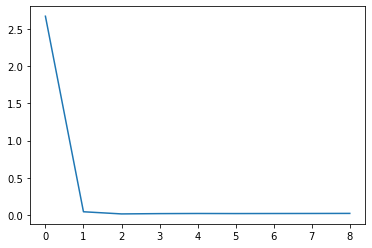

In [33]:
pd.DataFrame(history.history)['val_loss'].plot()

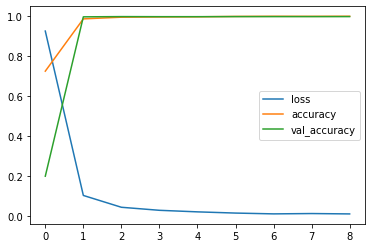

In [34]:
pd.DataFrame(history.history)[['loss','accuracy','val_accuracy']].plot()

## Model Evaluation

In [35]:
test_generator=train_datagen.flow_from_directory(
    test_data_dir,
    color_mode="rgb",
    target_size=(W,H),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 2476 images belonging to 10 classes.


In [36]:
class_names=list(test_generator.class_indices.keys())
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [37]:
class_labels= test_generator.class_indices
class_labels={v:k for k,v in class_labels.items()}


In [38]:
y_true=test_generator.classes
y_pred_probs=model_digits.predict_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [39]:
y_pred=np.argmax(y_pred_probs,axis=1)

In [40]:
model_digits.evaluate_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.016591981053352356, 0.9963651299476624]

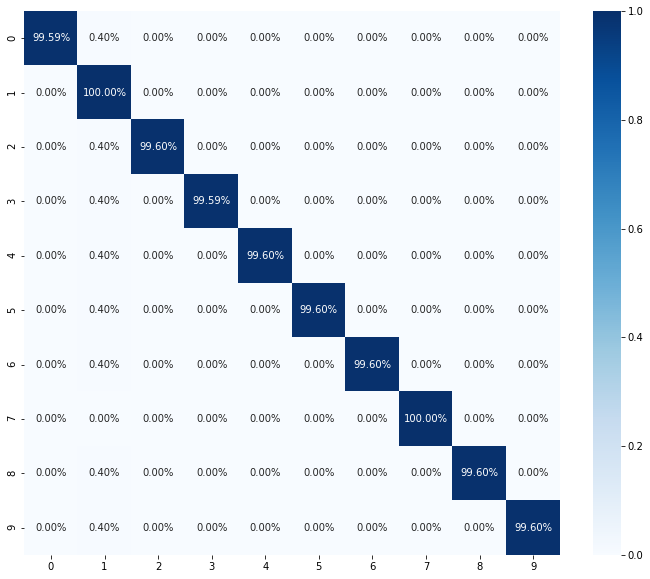

In [41]:
cnf=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cnf/np.sum(cnf,axis=1),annot=True,fmt='.2%',cmap='Blues',)
plt.show()

In [42]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       246
           1       0.97      1.00      0.98       248
           2       1.00      1.00      1.00       247
           3       1.00      1.00      1.00       245
           4       1.00      1.00      1.00       247
           5       1.00      1.00      1.00       248
           6       1.00      1.00      1.00       248
           7       1.00      1.00      1.00       247
           8       1.00      1.00      1.00       249
           9       1.00      1.00      1.00       251

    accuracy                           1.00      2476
   macro avg       1.00      1.00      1.00      2476
weighted avg       1.00      1.00      1.00      2476



In [ ]:
!zip -r /content/drive/MyDrive/Unlimited/Datasets/CC_Num_reader/Dataset.zip /content/Dataset/

In [44]:
# !rm -r /content/Dataset

In [ ]:
!unzip /content/drive/MyDrive/Unlimited/Datasets/CC_Num_reader/Dataset.zip

In [46]:
classifier=tensorflow.keras.models.load_model('./content/Dataset/trained_model/digits.hd5')

# Number Extraction from CC

In [47]:
def cordinates(pts):
  rect=np.zeros((4,2),dtype='float32')
  s=pts.sum(axis=1)

  rect[0]=pts[np.argmin(s)] # the top-left point will have the smallest sum
  rect[2] = pts[np.argmax(s)] # the bottom-right point will have the largest sum
  diff = np.diff(pts, axis = 1)
  rect[1] = pts[np.argmin(diff)] # top-right point will have the smallest difference
  rect[3] = pts[np.argmax(diff)] # the bottom-left will have the largest difference

  return rect

In [48]:
def four_point_transform(image,pts):
  rect=cordinates(pts)
  (tl,tr,br,bl)=rect

  widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
  widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
  maxWidth = max(int(widthA), int(widthB))

  heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
  heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
  maxHeight = max(int(heightA), int(heightB))

  # For bird eye view
  distance=np.array([[0,0],[maxWidth-1,0],[maxWidth-1,maxHeight-1],[0,maxHeight-1]],dtype='float32')

  M=cv2.getPerspectiveTransform(rect,distance)

  warped=cv2.warpPerspective(image,M,(maxWidth,maxHeight))

  return warped

In [73]:
def doc_scan(image):
  o_H,o_W=image.shape[0],image.shape[1]
  ratio=image.shape[0]/500.0

  orig=image.copy()

  image= imutils.resize(image,height=500)
  o_H,o_W=image.shape[0],image.shape[1]
  o_area=o_H*o_W

  # Blurring, greyscaling,finding edges

  gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  gray=cv2.GaussianBlur(gray,(5,5),0)
  edged=cv2.Canny(gray,75,200)

  # cv2.imshow("Image",image)
  cv2_imshow(image)
  # cv2.imshow("Edged",edged)
  cv2_imshow(edged)
  # cv2.waitkey(0)

  # Finding contours in edged image

  contours,hierarchy=cv2.findContours(edged.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
  contours=sorted(contours,key=cv2.contourArea,reverse=True)[:5]

  for c in contours:
    area=cv2.contourArea(c)
    if area<(o_area/3):
      print("Invalid Image")
      continue

    perimeter=cv2.arcLength(c,True)

    approx=cv2.approxPolyDP(c,0.02*perimeter,True)

    #if our approximated contour has four points, then we can assume that we have found our screen    

    if len(approx)==4:
      screen_count=approx
      break

  cv2.drawContours(image,[screen_count],-1,(0,255,0),2)
  # cv2.imshow("Outline",image)
  cv2_imshow(image)

  warped=four_point_transform(orig,screen_count.reshape(4,2)*ratio)
  cv2.resize(warped,(640,403),interpolation=cv2.INTER_AREA) # To improve the classification model as actual ratio of a credit card is 640:403
  cv2.imwrite("credit_card.jpg",warped)
  warped=cv2.cvtColor(warped,cv2.COLOR_BGR2GRAY)
  warped=warped.astype('uint8')*255
  # cv2.imshow("Extracted Credit Card",warped)
  cv2_imshow(warped)
  # cv2.waitKey(0)
  # cv2.destroyAllWindows()
  return warped



In [74]:
image = cv2.imread('test_card.jpg')

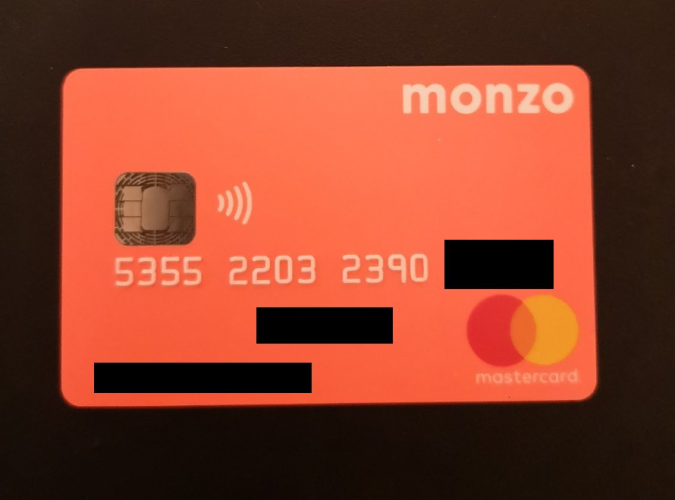

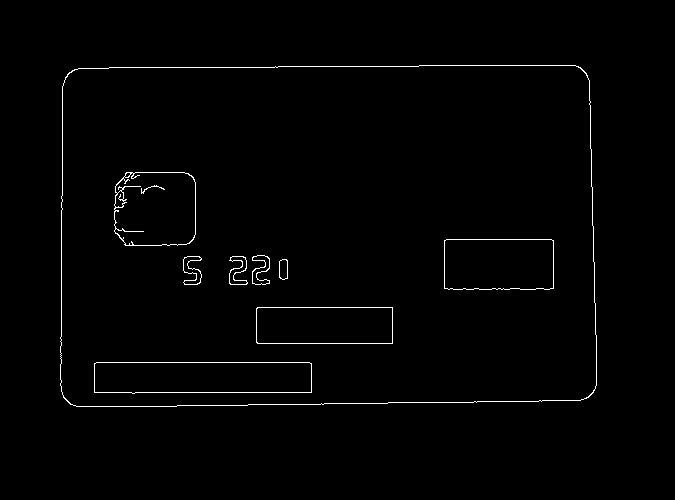

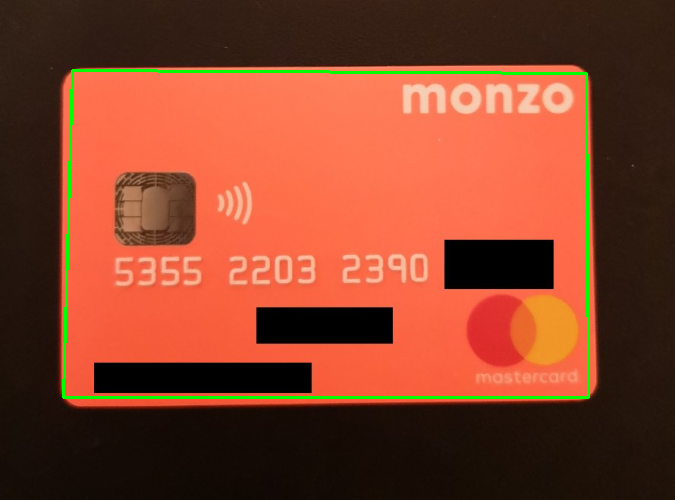

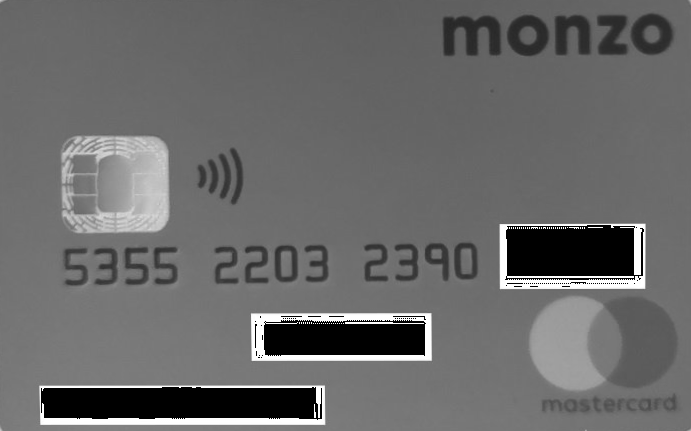

In [75]:
image = doc_scan(image)

In [88]:
region = [(55, 240), (640, 290)]

top_left_y = region[0][1]
bottom_right_y = region[1][1]
top_left_x = region[0][0]
bottom_right_x = region[1][0]


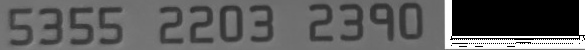

True

In [89]:
roi = image[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
# cv2.imshow("Region", roi)
cv2_imshow(roi)
cv2.imwrite("credit_card_extracted_digits.jpg", roi)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [90]:
def x_cord_contour(contours):
    '''Returns the X cordinate for the contour centroid'''
    if cv2.contourArea(contours) > 10:
        M = cv2.moments(contours)
        return (int(M['m10']/M['m00']))
    else:
        pass

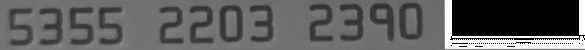

In [91]:
img = cv2.imread('credit_card_extracted_digits.jpg')
orig_img = cv2.imread('credit_card_color.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
cv2_imshow(img)
# cv2.imshow("image", img)
# cv2.waitKey(0)

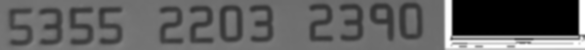

In [92]:
# Blur image then find edges using Canny 
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
cv2_imshow(blurred)
#cv2.imshow("blurred", blurred)
#cv2.waitKey(0)

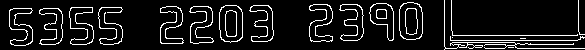

In [93]:
edged = cv2.Canny(blurred, 30, 150)
cv2_imshow(edged)
#cv2.imshow("edged", edged)
#cv2.waitKey(0)


In [94]:
contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [95]:
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:13] # 16 to get all digits
contours = sorted(contours, key = x_cord_contour, reverse = False)

In [96]:
def pre_process(image, inv = False):
    """Uses OTSU binarization on an image"""
    try:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    except:
        gray_image = image
        pass
    
    if inv == False:
        _, th2 = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        _, th2 = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    resized = cv2.resize(th2, (32,32), interpolation = cv2.INTER_AREA)
    return resized

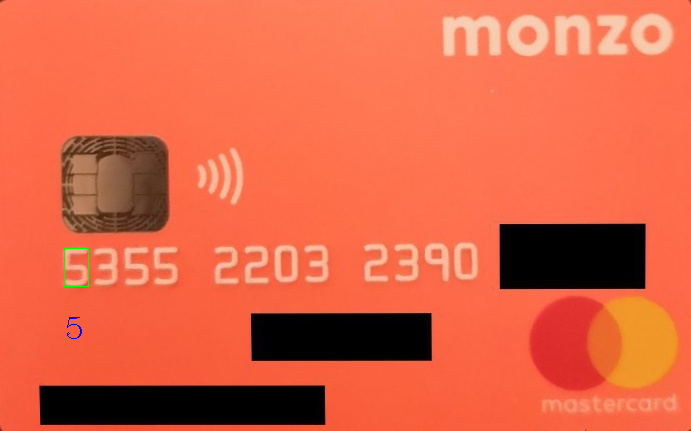

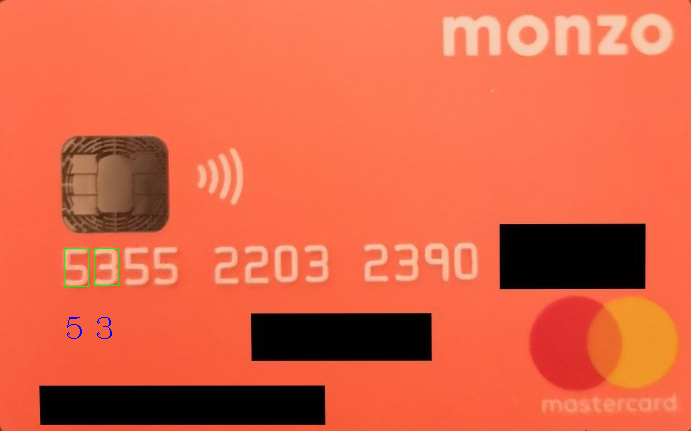

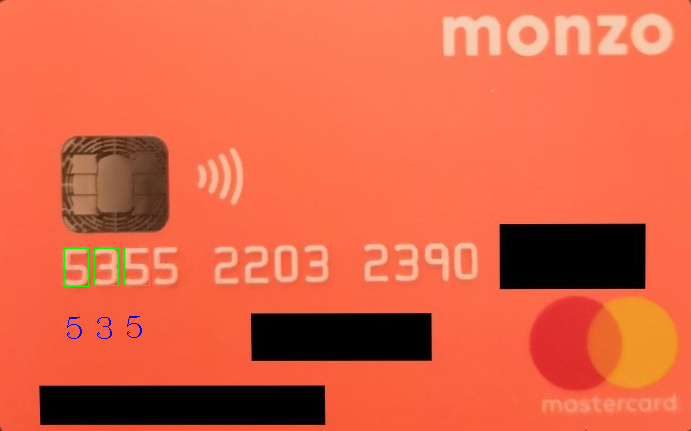

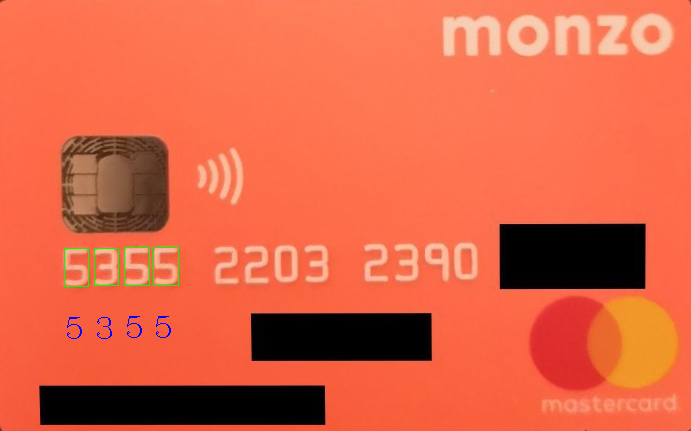

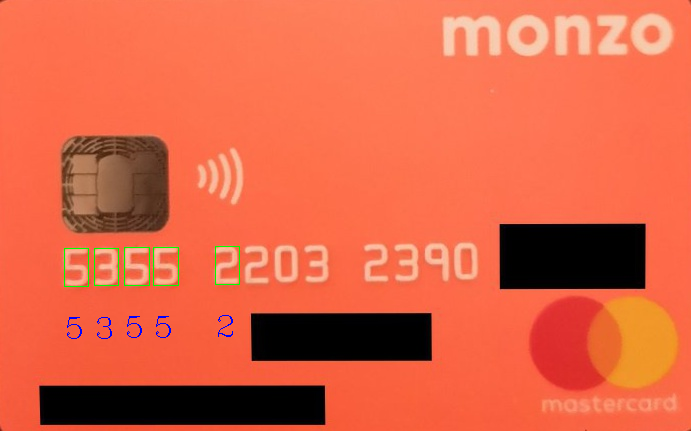

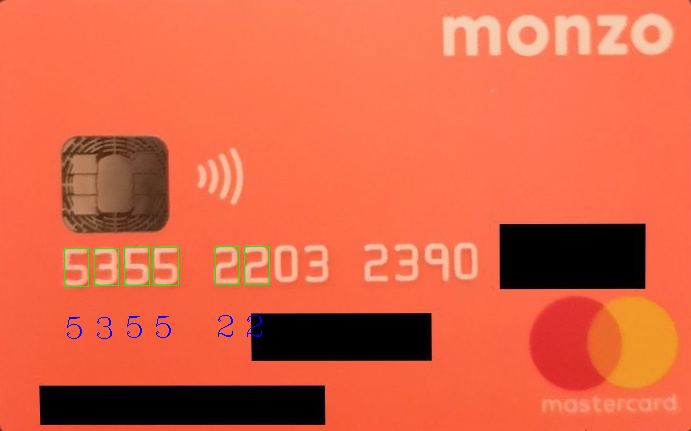

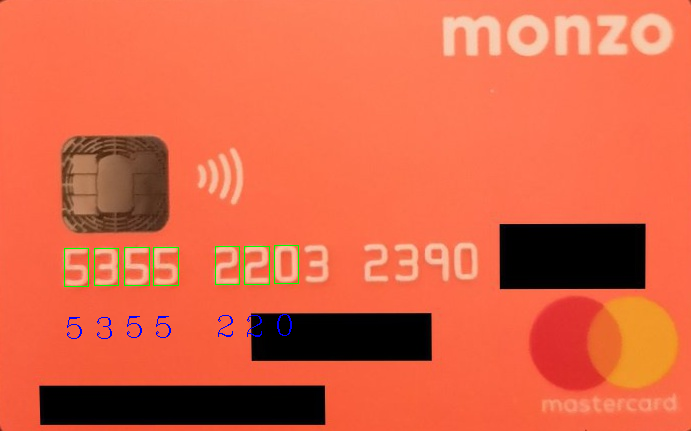

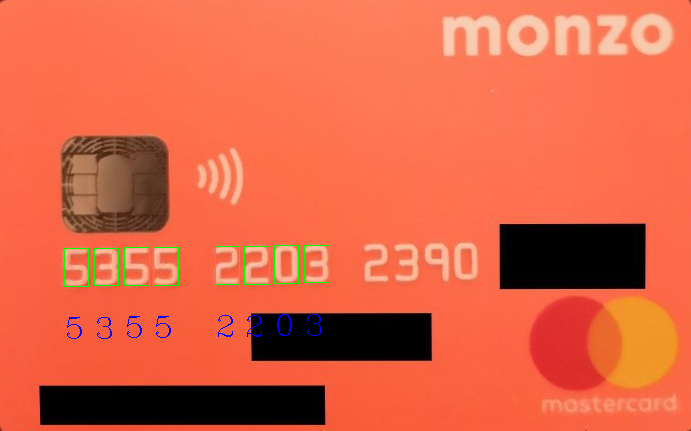

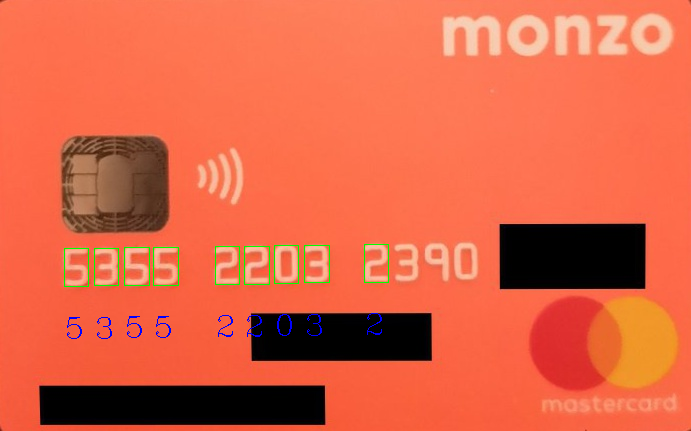

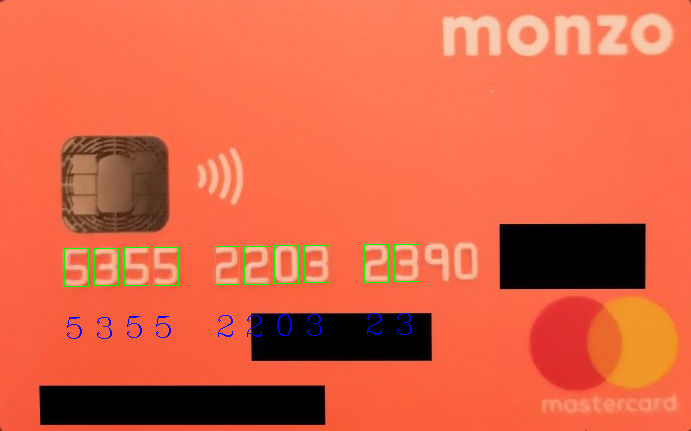

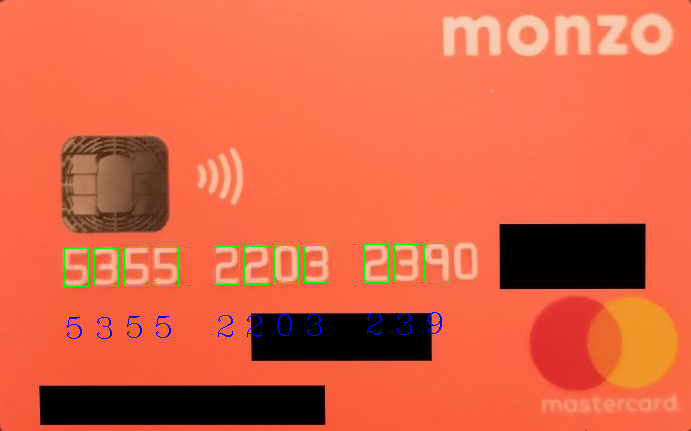

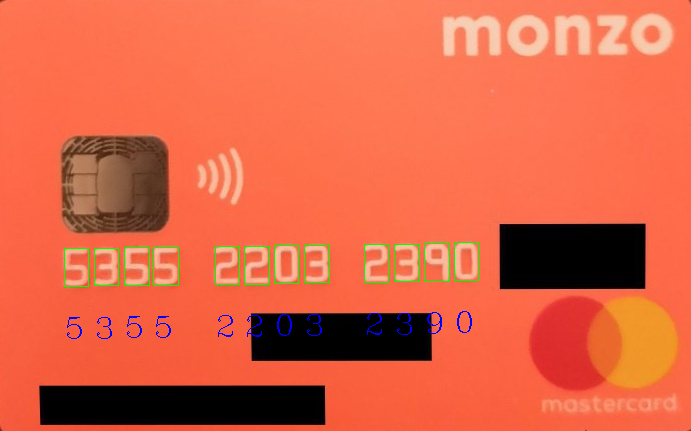

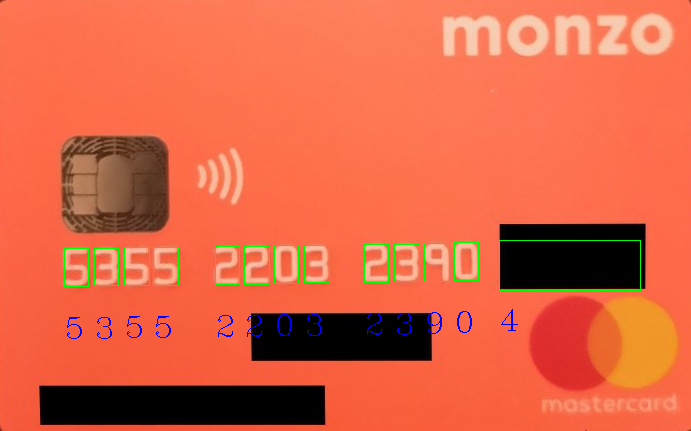

In [98]:
full_number = []
orig_img = cv2.imread('credit_card_color.jpg')
for c in contours:
    # compute the bounding box for the rectangle
    (x, y, w, h) = cv2.boundingRect(c)    
    if w >= 5 and h >= 25 and cv2.contourArea(c) < 1000:
        roi = blurred[y:y + h, x:x + w]
        # cv2_imshow(roi)
        # cv2.imshow("ROI1", roi)
        roi_otsu = pre_process(roi, True)
        # cv2_imshow(roi_otsu)
        # cv2.imshow("ROI2", roi_otsu)
        roi_otsu = cv2.cvtColor(roi_otsu, cv2.COLOR_GRAY2RGB)
        roi_otsu = tensorflow.keras.preprocessing.image.img_to_array(roi_otsu)
        roi_otsu = roi_otsu * 1./255
        roi_otsu = np.expand_dims(roi_otsu, axis=0)
        image = np.vstack([roi_otsu])
        label = str((np.argmax(classifier.predict(image,batch_size=10)))%10)
        full_number.append(label)
        (x, y, w, h) = (x+region[0][0], y+region[0][1], w, h)
        cv2.rectangle(orig_img, (x, y), (x + w, y + h), (0, 255, 0), 1)
        cv2.putText(orig_img, label, (x , y + 90), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 0, 0), 1)
        cv2_imshow(orig_img)
        # cv2.imshow("image", orig_img)
        # cv2.waitKey(0) 
        
# cv2.destroyAllWindows()

In [100]:
full_number

['5', '3', '5', '5', '2', '2', '0', '3', '2', '3', '9', '0', '4']

In [101]:
number=''.join(full_number)
print(int(number))

5355220323904
